# PyTorch policy gradient example at openai-gym pong
**Reference**
1. Karpathy pg-pong.py: https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5
2. PyTorch official example: https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py


In this exercise, your will implement Policy Gradient on Pong. Go through the code-blocks and notice, what happens. The exercise description is at the bottom of the notebook.


### Imports

In [1]:
!pip install gym[atari]
!pip install gym[accept-rom-license]

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import argparse
import gym
import numpy as np
from itertools import count
import matplotlib.pyplot as plt

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

is_cuda = torch.cuda.is_available()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

Let's set-up the environment and parameters

In [3]:
# Parameters
seed = 87 #random seed (default: 87)
batch_size = 10 #Every how many episodes to da a param update
learning_rate = 1e-4  # learning rate (default: 1e-4)
decay_rate = 0.99 # decay rate for RMSprop (default: 0.99)
gamma = 0.99 #discount factor (default: 0.99
test = False # whether to test the trained model or keep training

#Environment
game = 'Pong-v0'

env = gym.make(game, render_mode='rgb_array')
env.seed(seed)
torch.manual_seed(seed)

#Only render frame when we are looking
if test ==True:
    render = True
else:
    render = False

n_actions = 2

#Path to save the trained model
savepath = 'pg_params_conv'+game+'.pkl'

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Let's see how the environment looks when we take random actions.

In [5]:
s = env.reset()

for _ in range(100):
    env.render(mode = 'rgb_array')
    #a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _ = env.step(np.random.randint(n_actions)+2)
    time.sleep(0.05)
    if done: break

env.close()
#show_replay()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarnin

Set-up preprocessing that crop-out the important part of the frame. In order to reduce the number of computations, the image is converted to a black/white iamge

In [6]:
def prepro(I):
    """ prepro 210x160x3 """
    I = I[35:195]
    I = I[::2, ::2, 0]
    I[I == 144] = 0
    I[I == 109] = 0
    I[I != 0 ] = 1
    return I.astype(float)

## Let's define our policy

In [7]:
class Policy(nn.Module):
    def __init__(self, num_actions= n_actions):
        super(Policy, self).__init__()
        self.conv1 =  nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=2)
        self.conv2 =  nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=2)
        self.affine3 = nn.Linear(4624, num_actions)

       # self.affine1 = nn.Linear(6400, 200)
        self.num_actions = num_actions
        self.saved_log_probs = []
        self.rewards = []
        rand_var = torch.tensor([0.5,0.5])
        rand_var = rand_var.to(device)
        self.random = Categorical(rand_var)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        action_scores = self.affine3(x.view(-1))

        return F.softmax(action_scores, dim=0)


    def select_action(self, x):
        x = Variable(torch.from_numpy(x).float().unsqueeze(0).unsqueeze(0))
        x = x.to(device)
        probs = self.forward(x)
        m = Categorical(probs)
        action = m.sample()

        self.saved_log_probs.append(m.log_prob(action))
        return action

# built policy network
policy = Policy()
policy.to(device)

# check & load pretrain model
if os.path.isfile(savepath):
    print('Load Policy Network parametets ...')
    policy.load_state_dict(torch.load(savepath, map_location=device))


# construct a optimal function
optimizer = optim.RMSprop(policy.parameters(), lr=learning_rate, weight_decay=decay_rate)


def finish_episode():
    R = 0
    policy_loss = []
    rewards = []
    for r in policy.rewards[::-1]: # run through the rewards
        R = r + gamma * R # And the current reward and down-weight later rewards
        rewards.insert(0, R) # store this reward in the reward list
    # turn rewards to pytorch tensor and standardize
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-6) # Standadize rewards so that this number does not explode, if the rounds are long

    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(- log_prob * reward)
    optimizer.zero_grad()
    policy_loss = torch.stack(policy_loss).sum()
    policy_loss.to(device)
    policy_loss.backward()
    optimizer.step()

    # bookkeeping
    losses.append(policy_loss.to('cpu').detach().numpy())

    # clean rewards and saved_actions
    del policy.rewards[:]
    del policy.saved_log_probs[:]

## Main loop

In [8]:
running_reward = None
reward_sum = 0
prev_x = None
training_rewards, losses = [], []

print('Action meaning:', env.env.get_action_meanings())

n_episodes = 50 # After few thousand episodes, the agent will play reasonable using the current policy network

for i_episode in range(n_episodes):
    state = env.reset()
    for t in range(10000):
        if render:
            env.render()
            time.sleep(0.02)

        cur_x = prepro(state)
        x = cur_x - prev_x if prev_x is not None else np.zeros(cur_x.shape)
        prev_x = cur_x
        action = policy.select_action(x)
        action_env = action + 2 # possible actions are left/right, which are on position 2 and 3 in the action space. Output is 0/1 -> therefore offset by 2. ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
        state, reward, done, _ = env.step(action_env)
        reward_sum += reward

        policy.rewards.append(reward)
        if done:
            # bookkeeping
            training_rewards.append(reward_sum)

            # tracking log
            running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
            print('REINFORCE ep %03d done. reward: %f. reward running mean: %f' % (i_episode, reward_sum, running_reward))
            reward_sum = 0
            break


    # use policy gradient update model weights
    if i_episode % batch_size == 0:
        finish_episode()

    # Save model in every 50 episode
    if i_episode % 50 == 0:
        print('ep %d: model saving...' % (i_episode))
        torch.save(policy.state_dict(), savepath)

Action meaning: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
REINFORCE ep 000 done. reward: -21.000000. reward running mean: -21.000000
ep 0: model saving...
REINFORCE ep 001 done. reward: -21.000000. reward running mean: -21.000000
REINFORCE ep 002 done. reward: -21.000000. reward running mean: -21.000000
REINFORCE ep 003 done. reward: -21.000000. reward running mean: -21.000000
REINFORCE ep 004 done. reward: -19.000000. reward running mean: -20.980000
REINFORCE ep 005 done. reward: -21.000000. reward running mean: -20.980200
REINFORCE ep 006 done. reward: -21.000000. reward running mean: -20.980398
REINFORCE ep 007 done. reward: -21.000000. reward running mean: -20.980594
REINFORCE ep 008 done. reward: -21.000000. reward running mean: -20.980788
REINFORCE ep 009 done. reward: -18.000000. reward running mean: -20.950980
REINFORCE ep 010 done. reward: -20.000000. reward running mean: -20.941470
REINFORCE ep 011 done. reward: -21.000000. reward running mean: -20.942056
REI

# Plot training results

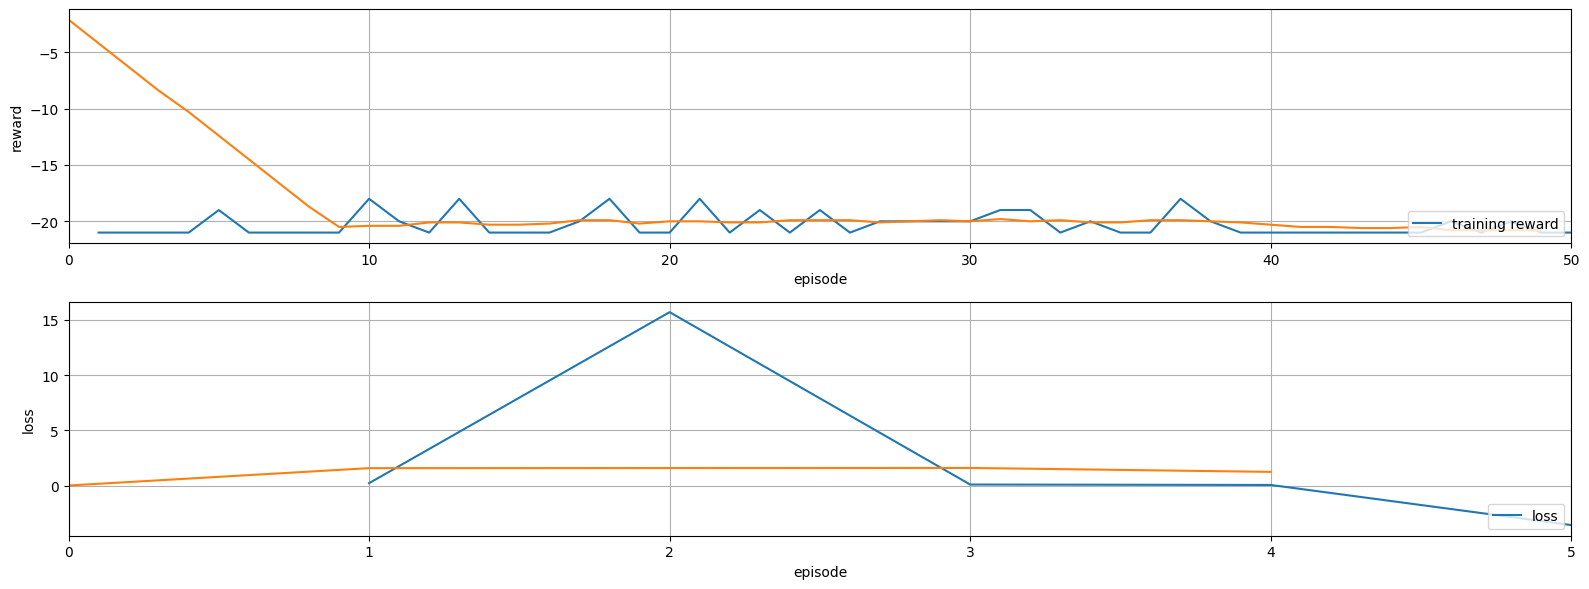

In [9]:
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers
* Choose another GYM-task https://gym.openai.com/